In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
df = pd.read_csv('data/preprocessed/dataset.csv')

C:\Users\benja\AppData\Local\Temp\ipykernel_30804\3622772722.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/preprocessed/dataset.csv')


In [10]:
df.head()

,ID,fire_id,INCIDENT_NUMBER,DONWCGU_PROT_UNIT_IDENTIFIER,INCIDENT_NAME,CAUSE_IDENTIFIER,DISCOVERY_DATE,INCIDENT_AREA,INC_AREA_UOM_IDENTIFIER,EST_IM_COST_TO_DATE,...,time_since_last_report,last_incident_area,time_until_next_report,next_incident_area,diff_incident_area,will_grow,rate_of_growth,next_incident_area_log1p,next_incident_area_sqrt,next_incident_area_square
0,763,2714022,150001,1525115.0,Bayle Mountain,1536120.0,2015-05-05 09:30:00,150.0,1536109.0,100.0,...,NaN,NaN,-2295.0,275.0,125.0,True,125.0,5.620401,16.583124,75625.0
1,763,2714022,150001,1525115.0,Bayle Mountain,1536120.0,2015-05-05 09:30:00,150.0,1536109.0,100.0,...,2295.0,150.0,-1440.0,275.0,0.0,False,0.0,5.620401,16.583124,75625.0
2,763,2714022,150001,1525115.0,Bayle Mountain,1536120.0,2015-05-05 09:30:00,150.0,1536109.0,100.0,...,1440.0,275.0,-2190.0,275.0,0.0,False,0.0,5.620401,16.583124,75625.0
3,763,2714022,150001,1525115.0,Bayle Mountain,1536120.0,2015-05-05 09:30:00,150.0,1536109.0,100.0,...,2190.0,275.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
4,764,2714081,150001,1524763.0,Boot Cove Fire,1536117.0,2015-05-06 20:30:00,206.0,1536109.0,15000.0,...,NaN,NaN,-1252.5,205.0,0.0,False,0.0,5.327876,14.317821,42025.0


In [11]:
from sklearn.preprocessing import OneHotEncoder

def create_task_dataset(df, features,target='next_incident_area'):
  """Feature and row selection, encoding

  Arguments:
      df {DataFrame} -- merged dataframe: incidents, reports, resources. A row is a report.
      features {List[str]} -- List of features to use for the task.
      target {str} -- target to predict
  """
  # Select features
  df = df[['fire_id', 'report_id']+ features + [target]]

  # Drop rows with missing values
  df = df.dropna(subset=[target])

  # Find categorical columns
  cat_cols = [col for col in df.columns if df[col].nunique() < 15]
  print(f"Identified {len(cat_cols)} categorical columns: \n{cat_cols}")
  potential = [col for col in df.columns if df[col].nunique() > 15 and df[col].nunique() < 100]
  print(f'\nYou should check these columns: \n{potential}')

  # One-hot encode categorical columns
  encoder = OneHotEncoder(sparse_output=False)
  encoded_data = encoder.fit_transform(df[cat_cols])
  encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_cols))
  df = df.drop(columns=cat_cols).reset_index(drop=True)
  encoded_df = pd.concat([df, encoded_df], axis=1)
  return encoded_df, encoder

In [12]:
features = ['report_number', 'incident_area', 'cause_id', 'month', 'year', 'STATUS']
target = 'diff_incident_area'
id_cols = ['fire_id', 'report_id']
task_df, _ = create_task_dataset(df, features, target)
non_id_cols = [col for col in task_df.columns if col not in id_cols]

Identified 4 categorical columns: 
['cause_id', 'month', 'year', 'STATUS']

You should check these columns: 
[]


## Viz

<Axes: >

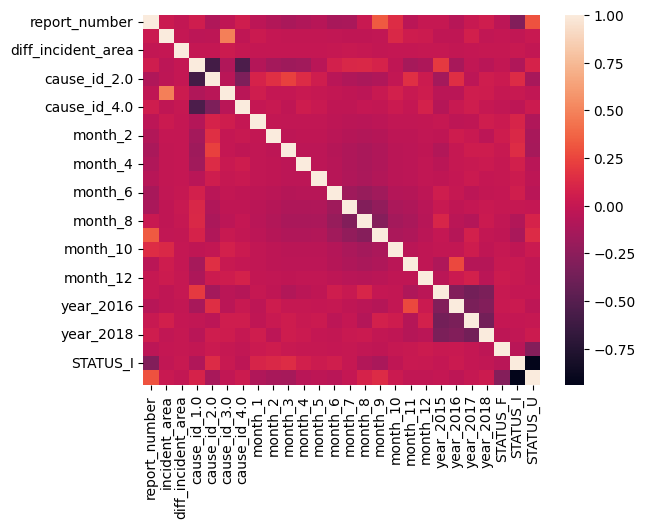

In [13]:
sns.heatmap(task_df[non_id_cols].corr())

In [18]:
task_df.corr()[target].sort_values(ascending=False)

diff_incident_area    1.000000
cause_id_3.0          0.033140
month_7               0.009234
STATUS_I              0.008233
year_2015             0.005336
month_6               0.004647
cause_id_4.0          0.003360
month_8               0.003338
month_12              0.003052
year_2018             0.001629
STATUS_F              0.001487
year_2017             0.000376
report_id             0.000206
fire_id               0.000203
month_4              -0.001724
month_3              -0.002047
month_1              -0.002405
month_5              -0.002495
month_11             -0.003061
month_2              -0.003963
cause_id_1.0         -0.004596
cause_id_2.0         -0.005203
month_10             -0.005639
incident_area        -0.006277
report_number        -0.007307
year_2016            -0.007707
month_9              -0.007800
STATUS_U             -0.008400
Name: diff_incident_area, dtype: float64

In [14]:
task_df[target].describe()

count    3.749900e+04
mean     6.206751e+02
std      2.020143e+04
min     -2.601403e+06
25%      0.000000e+00
50%      0.000000e+00
75%      8.400000e+01
max      2.627860e+06
Name: diff_incident_area, dtype: float64

## Train/test split

In [15]:
def split_train_test(task_df, id_cols, target, test_size=0.2, random_state=42):
  """Split data into train and test sets

  Arguments:
      task_df {DataFrame} --
      id_cols {List[str]} -- identifiers columns
      target {str} -- target feature

  Returns:
      DataFrame -- train set
      DataFrame -- test set
  """
  df = task_df.sample(frac=1, random_state=random_state)
  unique_ids = df['fire_id'].unique()
  train_ids, test_ids = train_test_split(unique_ids,)
  train_df = df[df['fire_id'].isin(train_ids)]
  test_df = df[df['fire_id'].isin(test_ids)]
  return  train_df, test_df
train_df, test_df = split_train_test(task_df, id_cols, target)
X_test, y_test = test_df.drop(columns=[target]+id_cols), test_df[target]


In [16]:
train_df.to_csv('data/preprocessed/train.csv', index=False)
test_df.to_csv('data/preprocessed/test.csv', index=False)

,fire_id,report_id,report_number,incident_area,diff_incident_area,cause_id_1.0,cause_id_2.0,cause_id_3.0,cause_id_4.0,month_1,...,month_10,month_11,month_12,year_2015,year_2016,year_2017,year_2018,STATUS_F,STATUS_I,STATUS_U
24985,7329525,7329699,18,782.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
19125,7180491,7181788,30,5189.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3077,2797929,2797943,2,2500.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
24526,7317722,7317889,6,320.0,71.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
32428,9133120,9133442,8,250.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,2757157,2757500,10,535.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
16023,4431809,4432032,6,12272.0,81.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
21962,7252431,7252432,8,40.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
860,2732760,2732857,6,2759.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Hyperparameter tuning with cross-validation


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models = {
    'regression':
        {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(),
        "Lasso": Lasso(),
        'XGB': xgb.XGBRegressor(),
        #'RandomForest': RandomForestRegressor(),
        #'SVR': SVR()
        },
    'classification':
        {
        'LogisticRegression': LogisticRegression(),
        'XGB': xgb.XGBClassifier(),
        'RandomForest': RandomForestClassifier(),
        'SVC': SVC()
        }
}

In [11]:
hyperparameters = {
    "LinearRegression": {},
    "Ridge": {
        "alpha": [0.001, 0.01, 0.1, 1, 10, 100],
    },
    "Lasso": {
        "alpha": [0.001, 0.01, 0.1, 1, 10, 100],
    },
    "XGB": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "subsample": [0.5, 1],
    },
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_features": [2, 3, 4],
        "max_depth": [None, 3, 5, 10],
    },
    "SVR": {
        "C": [0.1, 1, 10, 100, 1000],
        "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
    },
}

In [12]:
hp_grid = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 1, 10]},
    "Lasso": {'alpha': [0.1, 1, 10], 'max_iter': [1000, 2000, 3000]},
    'XGB': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'criterion': ["squared_error"]},
    'SVR': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.1, 1, 10]}
}

In [15]:
from sklearn.model_selection import GroupKFold, GridSearchCV, RandomizedSearchCV
import pickle

SCORING_METRIC = 'r2' #'neg_mean_absolute_error'
RANDOM_STATE = 42
def compute_cv_scores(train_df, target, n_splits, models, save_models=False):
  """Compute the score of each model

  Arguments:
      X {DataFrame} -- features
      y {Series} -- target
      n_plit {int} -- number of cv splits
      models {Dict} -- dict of models

  Returns:
      DataFrame -- scores
  """
  searches = {}
  X = train_df.drop(columns=id_cols+[target])
  y = train_df[target]
  gkf = GroupKFold(n_splits=n_splits)
  for model_name, model in models.items():
    print(f"Running RandomizedSearchCV for {model.__class__.__name__}")
    search = RandomizedSearchCV(
            model,
            hp_grid[model_name],
            scoring=SCORING_METRIC
            cv=gkf.split(X, y, groups=train_df["fire_id"]),
            refit=True,
            random_state=RANDOM_STATE,
            n_jobs=-1,
        )
    search.fit(X, y)
    searches[model_name] = search

    if save_models:
        with open(f"models/{model_name}.pkl", "wb") as f:
                pickle.dump(search.best_estimator_, f)
  return searches

In [16]:
searches = compute_cv_scores(train_df, target, 5, models['regression'])

Running RandomizedSearchCV for LinearRegression


c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running RandomizedSearchCV for Ridge


c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.03018e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running RandomizedSearchCV for Lasso
Running RandomizedSearchCV for XGBRegressor


c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [37]:
searches_details = {}
for model in searches.keys():
  print(model)
  model_details = {}
  model_details['cv_results'] = searches[model].cv_results_
  model_details['best_params'] = searches[model].best_params_
  model_details['best_score'] = searches[model].best_score_
  model_details['std_dev'] = searches[model].cv_results_['std_test_score'][searches[model].best_index_]
  searches_details[model] = model_details

pd.DataFrame(searches_details)

LinearRegression
Ridge
Lasso
XGB


,LinearRegression,Ridge,Lasso,XGB
cv_results,"{'mean_fit_time': [0.0779109001159668], 'std_f...","{'mean_fit_time': [0.05377631187438965, 0.0502...","{'mean_fit_time': [1.7760169506072998, 1.67909...","{'mean_fit_time': [2.17462100982666, 4.4664372..."
best_params,{},{'alpha': 10},"{'max_iter': 1000, 'alpha': 10}","{'n_estimators': 100, 'max_depth': 7}"
best_score,-1583.228356,-1578.084673,-1538.997989,-3060.71758
std_dev,293.963706,293.996913,291.699443,2386.477759


In [38]:
searches['XGB'].cv_results_

{'mean_fit_time': array([ 2.17462101,  4.46643724,  6.68123202,  4.03917656,  7.8571671 ,
        11.52223654,  5.87967749, 10.53103342, 12.60266347]),
 'std_fit_time': array([0.1745525 , 0.41413394, 0.36838021, 0.4259646 , 0.72106473,
        0.8267958 , 0.56617737, 0.86063975, 0.2274547 ]),
 'mean_score_time': array([0.02426043, 0.03773971, 0.04237127, 0.03615913, 0.05848527,
        0.07861562, 0.05125632, 0.0628777 , 0.06335649]),
 'std_score_time': array([0.00173954, 0.0128015 , 0.00333747, 0.00519146, 0.00808273,
        0.00699355, 0.00811811, 0.00949114, 0.01581755]),
 'param_n_estimators': masked_array(data=[100, 200, 300, 100, 200, 300, 100, 200, 300],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7],
              mask=[False, False, False, False, False, False, False, False,
                    False],
  

In [21]:
searches.keys()

TypeError: 'dict_keys' object is not subscriptable

In [ ]:
import pickle
filename = "cv_scores_and_params.pkl"
with open(filename, "wb") as file:
    pickle.dump((scores, best_params, cv_results, best_estimators), file)


In [ ]:
model = LinearRegression()

X = train_df.drop(columns=id_cols+[target])
y = train_df[target]
gkf = GroupKFold(n_splits=5)
search = GridSearchCV(
    model,
    {},
    scoring="neg_mean_absolute_error",
    cv=gkf.split(X, y, groups=train_df["fire_id"]),
    refit=True,
)
search.fit(X, y)
print(search.best_score_)
print(search.best_params_)
print(search.score(X_test, y_test))
print(search.best_estimator_.score(X_test, y_test))
print(search.best_estimator_.score(X_test, y_test))

-1505.7074005633647
{}
-1700.3869589388794
-0.0018809173035405635
-0.0018809173035405635


In [98]:
test_scores = {}
for model_name in models['regression']:
  estimator = best_estimators[model_name]
  #estimator.fit(train_df.drop(columns=id_cols+[target]), train_df[target])
  test_scores[model_name] = estimator.score(X_test, y_test)
  break
test_scores

{'LinearRegression': -0.0018809173035405635}

In [88]:
estimator.fit(train_df.drop(columns=id_cols+[target]), train_df[target])

LinearRegression()

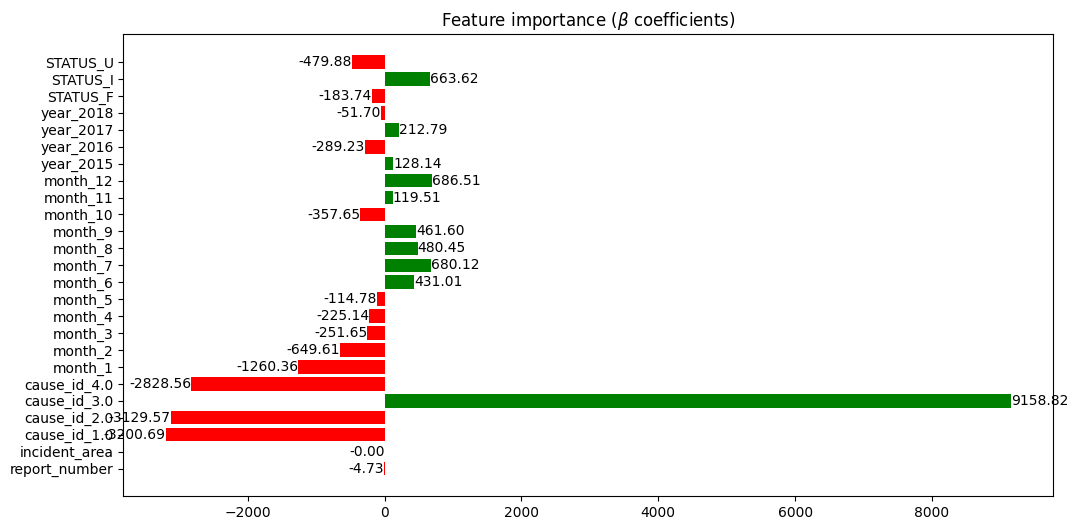

In [95]:
plt.figure(figsize=(12, 6))

colors = ["green" if c > 0 else "red" for c in estimator.coef_]
bars = plt.barh(X_test.columns, estimator.coef_, color=colors)

# Annotate the bars with their values
for bar in bars:
    width = bar.get_width()
    label_x_pos = width if width > 0 else width - 0.1
    plt.text(
        label_x_pos,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2f}",
        va="center",
        ha="right" if width < 0 else "left",
    )

plt.title(r"Feature importance ($\beta$ coefficients)")
plt.show()

R2:  -0.0018809173035405635


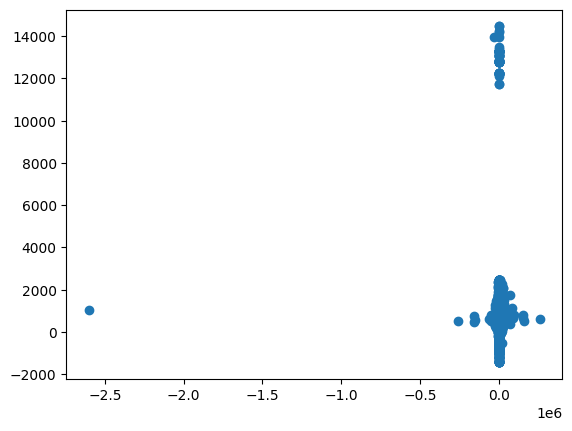

In [97]:
y_pred = estimator.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)
plt.scatter(y_test, y_pred)

In [ ]:
## Interpretation
.plot_importance(bst)
xgb.to_graphviz(bst, num_trees=2)

In [150]:
model = LassoCV(cv=gkf.split(X, y, groups=train_df['fire_id']))
reg = model.fit(X, y)
reg.score(X, y)

2.687558603775564e-06

In [149]:
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

array([-0.00000000e+00, -1.88066245e-05, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

In [ ]:
# possible improvements:
# - add more features
# - kfold stratified per year
# -

In [131]:
for x,y2 in :
  print(x)

[    0     1     2 ... 28668 28669 28670]
[    0     1     2 ... 28668 28669 28670]
[    0     1     2 ... 28668 28669 28670]
[    0     1     2 ... 28664 28665 28666]
[    0     1     2 ... 28668 28669 28670]
[    0     1     2 ... 28668 28669 28670]
[    0     1     2 ... 28668 28669 28670]
[    0     1     2 ... 28668 28669 28670]
[    3     4     5 ... 28668 28669 28670]
[    0     1     2 ... 28668 28669 28670]


In [107]:
print(f"Train set shape: {train_df.shape}")

Train set shape: (27646, 28)


In [92]:
model = LassoCV()
reg = model.fit(X, y)

In [94]:
reg.score(X, y)

2.5966450493131177e-05

In [ ]:
def predict(X_train, y_train, X_test, y_test, model=LinearRegression()):
  """Train and predict using a model

  Arguments:
      X_train {DataFrame} -- training data
      y_train {Series} -- training target
      X_test {DataFrame} -- test data
      y_test {Series} -- test target

  Keyword Arguments:
      model {sklearn model} -- model to use (default: {LinearRegression()})

  Returns:
      y_pred {Series} -- predictions
      model {sklearn model} -- trained model
  """
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return y_pred, model

In [ ]:
from sklearn.model_selection import KFold
KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
print("Intercept: ", linear_regression_model.intercept_)
print("Coefficients: ", linear_regression_model.coef_)
y_pred = linear_regression_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for Linear Regression Model')
plt.show()